In [1]:
import gym
import numpy as np
from blackjack_env import BlackjackEnv 
from blackjack_double_env import BlackjackDoubleEnv
from blackjack_double_env_count import BlackjackDoubleEnvWithCount

from tqdm import tqdm 
from collections import defaultdict
import random
from matplotlib import pyplot as plt

In [2]:
MEAN = 100_000

1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.


In [3]:
def simple_policy(env):
    player, _, _ = env._get_obs()
    return player < 19


def run_episode_simple(env, policy):
    env.reset()
    state = env._get_obs()
    rewards = [] 
    terminated = False
    
    while not terminated:
        action = policy(env)
        state, reward, terminated, _, _ = env.step(action)
        rewards.append(reward)
    return rewards


def run_experiments_simple(env, policy, num_experiments = 500_000):
    all_rewards = []
    
    for i in tqdm(range(num_experiments)):
        rewards = run_episode_simple(env, policy)
        all_rewards.append(rewards[-1])

    mean_reward = np.mean(all_rewards)

    print(f"mean reward: {mean_reward}")
    return mean_reward

In [4]:
env = BlackjackEnv(natural=True)
run_experiments_simple(env, simple_policy)
env.close()

100%|████████████████████████████████| 500000/500000 [00:37<00:00, 13236.81it/s]

mean reward: -0.180732


2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.


In [5]:
def epsilon_greedy_policy(env, epsilon, Q):
    state = env._get_obs()
    if random.random() > epsilon:
        return Q[state].argmax()
    else:
        return random.randint(0, env.action_space.n - 1)
    

def run_episode_mc_control(env, policy, epsilon, Q):
    env.reset()
    state = env._get_obs()
    episode = []
    
    terminated = False
    while not terminated:
        action = policy(env, epsilon, Q)
        next_state, reward, terminated, _, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
    return episode


def run_experiments_mc_control(env, policy, number_of_experiments, gamma, epsilon):
    alpha = 0.9
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    state_action_counter = defaultdict(int)
    
    mean_game_rewards = []
    
    for i in tqdm(range(number_of_experiments + 1)):
        episode = run_episode_mc_control(env, policy, epsilon, Q)
        G = 0
        for state, action, reward in reversed(episode):
            G = reward + gamma * G
            state_action_counter[(state, action)] += 1
            Q[state][action] = Q[state][action] + (G - Q[state][action]) * alpha / state_action_counter[(state, action)]
        
        if (i % MEAN == 0):
            evaluation = evaluate(env, policy, Q, epsilon)
            mean_game_rewards.append(evaluation)
            print(evaluation)
    return mean_game_rewards


def evaluate(env, policy, Q, epsilon, iterations = MEAN):
    rewards = []
    for _ in range(iterations):
        state = env.reset()
        terminated = False
        while not terminated:
            action = policy(env, epsilon, Q)
            state, reward, terminated, _, _ = env.step(action)
            rewards.append(reward)
    reward_result = np.mean(rewards)
    return reward_result


def plot(results_dict, title):
    fig = plt.figure(figsize = (14, 8))
    for result in results_dict:
        mean = results_dict[result]
        plt.plot(np.array(list(range(1, (len(mean)) * MEAN, MEAN))), mean, label = f"gamma = {result[0]}, epsilon = {result[1]}")
        plt.legend()
        plt.title(title)
        plt.ylabel("reward")
        plt.xlabel("experiments")
        plt.grid(True)

3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [6]:
gammas = [1, 0.6, 0.2]
epsilons = [0.0, 0.001, 0.005]

results_dict = defaultdict() 
for gamma in gammas:
    for epsilon in epsilons:
        env = BlackjackEnv(natural=True)
        print(f"current experiment gamma = {gamma}, epsilon = {epsilon}")
        mean_game_rewards_mc = run_experiments_mc_control(env, epsilon_greedy_policy, 500_000, gamma, epsilon)
        results_dict[(gamma, epsilon)] = mean_game_rewards_mc
        print(f"current experiment with gamma = {gamma}, epsilon = {epsilon} has finished")
        env.close()

current experiment gamma = 1, epsilon = 0.0


  0%|▏                                   | 2486/500001 [00:06<13:34, 610.59it/s]

-0.16692021636240703


 20%|██████▉                           | 101835/500001 [00:22<09:07, 727.33it/s]

-0.08163338497733402


 40%|█████████████▋                    | 201657/500001 [00:37<06:41, 742.46it/s]

-0.07934010479760872


 60%|████████████████████▌             | 302375/500001 [00:53<04:21, 756.32it/s]

-0.08157657141219296


 80%|███████████████████████████▎      | 401729/500001 [01:08<02:08, 766.69it/s]

-0.0816140733200476


100%|█████████████████████████████████| 500001/500001 [01:23<00:00, 5978.42it/s]


-0.08193245603317546
current experiment with gamma = 1, epsilon = 0.0 has finished
current experiment gamma = 1, epsilon = 0.001


  0%|▏                                   | 2051/500001 [00:06<16:16, 510.04it/s]

-0.1581231542820656


 20%|██████▉                           | 102178/500001 [00:22<08:35, 772.14it/s]

-0.0867513543807211


 40%|█████████████▋                    | 201898/500001 [00:37<06:13, 797.35it/s]

-0.08098831959239709


 60%|████████████████████▌             | 302423/500001 [00:52<04:05, 805.05it/s]

-0.0801849230224739


 80%|███████████████████████████▎      | 402223/500001 [01:07<02:04, 783.45it/s]

-0.06823968457196065


100%|█████████████████████████████████| 500001/500001 [01:21<00:00, 6102.77it/s]


-0.0689094383104097
current experiment with gamma = 1, epsilon = 0.001 has finished
current experiment gamma = 1, epsilon = 0.005


  1%|▏                                   | 2582/500001 [00:06<12:34, 659.10it/s]

-0.172233705800705


 20%|██████▉                           | 101674/500001 [00:21<08:23, 791.75it/s]

-0.04814491306879627


 40%|█████████████▋                    | 201245/500001 [00:36<06:24, 776.09it/s]

-0.05211357384863749


 60%|████████████████████▍             | 301373/500001 [00:52<04:17, 771.68it/s]

-0.03667718148852132


 80%|███████████████████████████▎      | 402346/500001 [01:07<02:03, 790.98it/s]

-0.035220037359149976


100%|█████████████████████████████████| 500001/500001 [01:22<00:00, 6066.97it/s]


-0.033820982100895625
current experiment with gamma = 1, epsilon = 0.005 has finished
current experiment gamma = 0.6, epsilon = 0.0


  0%|▏                                   | 2425/500001 [00:06<13:40, 606.09it/s]

-0.156388424057486


 20%|██████▉                           | 101555/500001 [00:22<08:47, 755.73it/s]

-0.06387991914100444


 40%|█████████████▋                    | 201514/500001 [00:37<06:35, 755.52it/s]

-0.06519291815296004


 60%|████████████████████▌             | 301778/500001 [00:53<04:18, 768.09it/s]

-0.0630924988495168


 80%|███████████████████████████▎      | 401736/500001 [01:08<02:10, 751.85it/s]

-0.06291154251868936


100%|█████████████████████████████████| 500001/500001 [01:23<00:00, 5970.30it/s]


-0.061223954920718124
current experiment with gamma = 0.6, epsilon = 0.0 has finished
current experiment gamma = 0.6, epsilon = 0.001


  0%|▏                                   | 2395/500001 [00:06<13:59, 592.95it/s]

-0.17323263625094965


 20%|██████▉                           | 101751/500001 [00:22<08:43, 760.92it/s]

-0.04826653633105246


 40%|█████████████▊                    | 202354/500001 [00:37<06:18, 786.67it/s]

-0.04683872061777673


 60%|████████████████████▍             | 301384/500001 [00:53<04:35, 722.06it/s]

-0.04288284163014326


 80%|███████████████████████████▎      | 401853/500001 [01:08<02:08, 762.89it/s]

-0.04126077852488653


100%|█████████████████████████████████| 500001/500001 [01:24<00:00, 5909.26it/s]


-0.03729476255656924
current experiment with gamma = 0.6, epsilon = 0.001 has finished
current experiment gamma = 0.6, epsilon = 0.005


  1%|▏                                   | 2538/500001 [00:06<13:19, 621.93it/s]

-0.1668140713504919


 20%|██████▉                           | 101363/500001 [00:22<09:01, 736.34it/s]

-0.03033715307677022


 40%|█████████████▋                    | 202048/500001 [00:38<07:03, 702.98it/s]

-0.026797957115319647


 60%|████████████████████▌             | 302148/500001 [00:53<04:23, 750.68it/s]

-0.023727464663671823


 80%|███████████████████████████▎      | 402280/500001 [01:09<02:12, 736.75it/s]

-0.020968766963682824


100%|█████████████████████████████████| 500001/500001 [01:24<00:00, 5905.21it/s]


-0.02135223094340619
current experiment with gamma = 0.6, epsilon = 0.005 has finished
current experiment gamma = 0.2, epsilon = 0.0


  0%|▏                                   | 2394/500001 [00:06<14:07, 587.29it/s]

-0.1729427202417639


 20%|██████▉                           | 101811/500001 [00:22<08:54, 745.43it/s]

-0.04205657944055855


 40%|█████████████▋                    | 201261/500001 [00:38<06:49, 728.78it/s]

-0.04213618598040709


 60%|████████████████████▌             | 302026/500001 [00:53<04:25, 746.31it/s]

-0.03871594591857403


 80%|███████████████████████████▎      | 402210/500001 [01:09<02:18, 704.29it/s]

-0.03925136798473418


100%|█████████████████████████████████| 500001/500001 [01:25<00:00, 5880.52it/s]


-0.04019412800790704
current experiment with gamma = 0.2, epsilon = 0.0 has finished
current experiment gamma = 0.2, epsilon = 0.001


  0%|▏                                   | 2454/500001 [00:06<13:45, 602.84it/s]

-0.16295981607357057


 20%|██████▉                           | 101796/500001 [00:22<09:13, 719.52it/s]

-0.03177930786885666


 40%|█████████████▋                    | 201913/500001 [00:38<06:49, 727.44it/s]

-0.02992678404159737


 60%|████████████████████▍             | 301204/500001 [00:54<04:27, 742.63it/s]

-0.02657271687884588


 80%|███████████████████████████▎      | 401665/500001 [01:09<02:15, 724.65it/s]

-0.02375087178240311


100%|█████████████████████████████████| 500001/500001 [01:25<00:00, 5868.88it/s]


-0.02311447994822869
current experiment with gamma = 0.2, epsilon = 0.001 has finished
current experiment gamma = 0.2, epsilon = 0.005


  0%|▏                                   | 2427/500001 [00:06<13:38, 608.24it/s]

-0.16827719767604368


 20%|██████▉                           | 101288/500001 [00:22<08:50, 751.86it/s]

-0.040405061639814756


 40%|█████████████▊                    | 202219/500001 [00:37<06:46, 731.67it/s]

-0.03536618870689204


 60%|████████████████████▌             | 302261/500001 [00:53<04:37, 711.98it/s]

-0.028978810698860248


 80%|███████████████████████████▎      | 402038/500001 [01:09<02:13, 731.20it/s]

-0.028726464435146443


100%|█████████████████████████████████| 500001/500001 [01:24<00:00, 5902.91it/s]

-0.021927113472565627
current experiment with gamma = 0.2, epsilon = 0.005 has finished


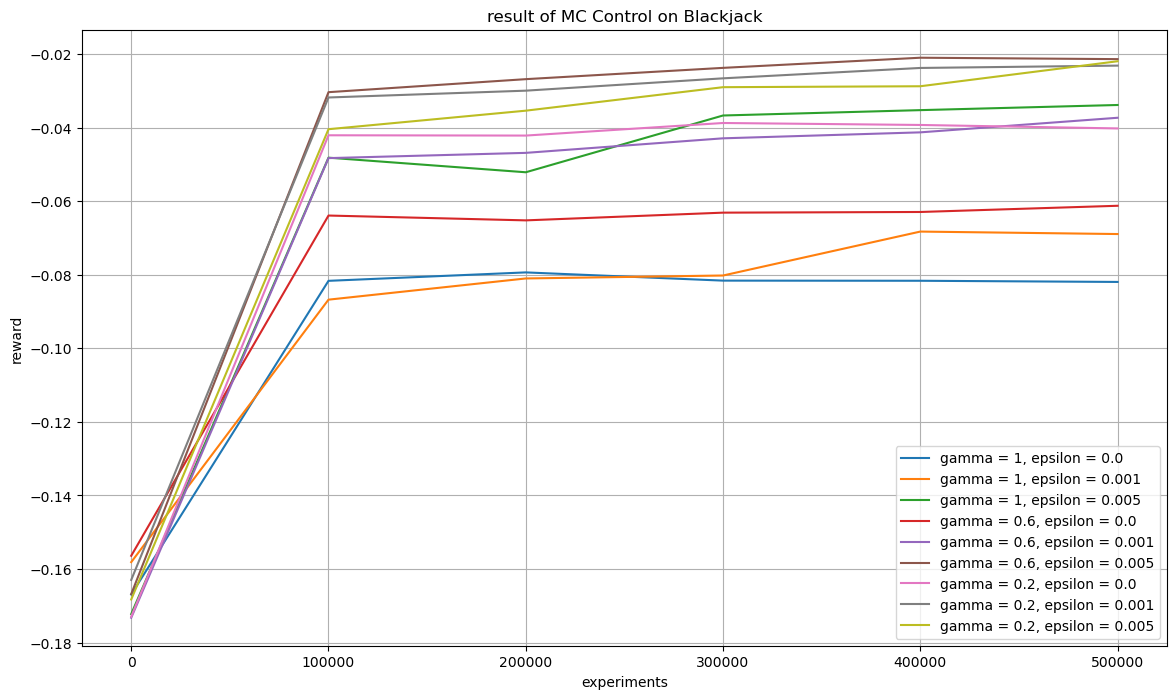

In [7]:
plot(results_dict, "result of MC Control on Blackjack")

4. Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.


Находится в файле blackjack_double_env.py

5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [8]:
gammas = [1, 0.6, 0.2]
epsilons = [0.0, 0.001, 0.005]
results_dict = defaultdict() 
for gamma in gammas:
    for epsilon in epsilons:
        env = BlackjackDoubleEnv(natural=True)
        print(f"current experiment gamma = {gamma}, epsilon = {epsilon}")
        mean_game_rewards_mc = run_experiments_mc_control(env, epsilon_greedy_policy, 1_000_000, gamma, epsilon)
        results_dict[(gamma, epsilon)] = mean_game_rewards_mc
        print(f"current experiment with gamma = {gamma}, epsilon = {epsilon} has finished")
        env.close()

current experiment gamma = 1, epsilon = 0.0


  0%|                                   | 2460/1000001 [00:07<30:59, 536.53it/s]

-0.5045078712570654


 10%|███▍                             | 102458/1000001 [00:23<19:06, 782.93it/s]

-0.09584239787285473


 20%|██████▋                          | 202310/1000001 [00:38<17:29, 760.05it/s]

-0.09860342391431627


 30%|█████████▉                       | 301282/1000001 [00:53<14:36, 797.45it/s]

-0.09697343557228304


 40%|█████████████▎                   | 401847/1000001 [01:08<12:44, 782.32it/s]

-0.09579526821269618


 50%|████████████████▌                | 501544/1000001 [01:23<10:38, 780.08it/s]

-0.09444800224922682


 60%|███████████████████▉             | 602565/1000001 [01:38<08:22, 790.43it/s]

-0.09706038342146724


 70%|███████████████████████▏         | 702474/1000001 [01:53<06:09, 804.15it/s]

-0.09748356558559543


 80%|██████████████████████████▍      | 801217/1000001 [02:08<04:13, 785.15it/s]

-0.09792752582789725


 90%|█████████████████████████████▋   | 901334/1000001 [02:23<02:04, 795.15it/s]

-0.09415227047407905


100%|███████████████████████████████| 1000001/1000001 [02:38<00:00, 6309.23it/s]


-0.09559299306946903
current experiment with gamma = 1, epsilon = 0.0 has finished
current experiment gamma = 1, epsilon = 0.001


  0%|                                   | 2423/1000001 [00:07<31:55, 520.83it/s]

-0.5189412133235878


 10%|███▎                             | 101453/1000001 [00:23<18:50, 794.48it/s]

-0.07762185093530488


 20%|██████▋                          | 201761/1000001 [00:38<18:06, 734.38it/s]

-0.07564545496988655


 30%|█████████▉                       | 302231/1000001 [00:53<15:04, 771.73it/s]

-0.07815103466809997


 40%|█████████████▎                   | 401585/1000001 [01:08<12:13, 816.32it/s]

-0.07170356111645813


 50%|████████████████▌                | 502371/1000001 [01:23<10:05, 821.26it/s]

-0.07044541859538334


 60%|███████████████████▊             | 601428/1000001 [01:38<08:27, 785.88it/s]

-0.06702351014004568


 70%|███████████████████████▏         | 701867/1000001 [01:53<06:06, 814.43it/s]

-0.06024888164670797


 80%|██████████████████████████▍      | 801702/1000001 [02:08<04:12, 784.93it/s]

-0.05969415577931903


 90%|█████████████████████████████▊   | 901706/1000001 [02:23<02:01, 808.57it/s]

-0.060278539549389686


100%|███████████████████████████████| 1000001/1000001 [02:38<00:00, 6314.31it/s]


-0.05857615360412558
current experiment with gamma = 1, epsilon = 0.001 has finished
current experiment gamma = 1, epsilon = 0.005


  0%|                                   | 2559/1000001 [00:07<29:57, 554.80it/s]

-0.5166421992466472


 10%|███▎                             | 102225/1000001 [00:22<18:33, 806.43it/s]

-0.07292169487920018


 20%|██████▋                          | 202041/1000001 [00:37<16:18, 815.82it/s]

-0.0635856650210832


 30%|█████████▉                       | 301547/1000001 [00:52<14:44, 790.00it/s]

-0.06131039385298605


 40%|█████████████▏                   | 401311/1000001 [01:07<12:46, 780.88it/s]

-0.054585170087374194


 50%|████████████████▌                | 502181/1000001 [01:23<11:03, 750.40it/s]

-0.05862697689167228


 60%|███████████████████▊             | 601743/1000001 [01:38<08:12, 808.96it/s]

-0.05364235780108039


 70%|███████████████████████▏         | 701662/1000001 [01:53<06:02, 823.02it/s]

-0.049394996774870414


 80%|██████████████████████████▍      | 801670/1000001 [02:08<04:13, 781.63it/s]

-0.044371417771709366


 90%|█████████████████████████████▊   | 902525/1000001 [02:23<02:01, 800.75it/s]

-0.044921769987633746


100%|███████████████████████████████| 1000001/1000001 [02:38<00:00, 6314.14it/s]


-0.028546790641871624
current experiment with gamma = 1, epsilon = 0.005 has finished
current experiment gamma = 0.6, epsilon = 0.0


  0%|                                   | 2520/1000001 [00:07<30:04, 552.89it/s]

-0.5151086496954259


 10%|███▎                             | 101393/1000001 [00:22<19:06, 784.04it/s]

-0.05524191037588991


 20%|██████▋                          | 201442/1000001 [00:38<17:17, 769.90it/s]

-0.05727072613517211


 30%|█████████▉                       | 301490/1000001 [00:53<14:44, 789.42it/s]

-0.0555787191460974


 40%|█████████████▏                   | 401370/1000001 [01:08<13:01, 766.24it/s]

-0.05697020661472921


 50%|████████████████▌                | 502400/1000001 [01:24<10:57, 756.26it/s]

-0.051940742387814945


 60%|███████████████████▊             | 602226/1000001 [01:39<08:38, 766.93it/s]

-0.057184862850866824


 70%|███████████████████████▏         | 701785/1000001 [01:54<06:24, 776.35it/s]

-0.05469157345161044


 80%|██████████████████████████▍      | 802139/1000001 [02:10<04:35, 718.87it/s]

-0.05769364628577792


 90%|█████████████████████████████▊   | 902066/1000001 [02:25<02:04, 783.86it/s]

-0.06223183427097169


100%|███████████████████████████████| 1000001/1000001 [02:41<00:00, 6203.51it/s]


-0.057790024609198985
current experiment with gamma = 0.6, epsilon = 0.0 has finished
current experiment gamma = 0.6, epsilon = 0.001


  0%|                                   | 2389/1000001 [00:08<32:41, 508.61it/s]

-0.5033509442621925


 10%|███▎                             | 101416/1000001 [00:23<19:43, 759.04it/s]

-0.07181141583769061


 20%|██████▋                          | 202216/1000001 [00:39<16:48, 791.08it/s]

-0.06429247687713932


 30%|█████████▉                       | 302443/1000001 [00:54<14:42, 790.28it/s]

-0.06195902427651327


 40%|█████████████▎                   | 402044/1000001 [01:09<13:22, 745.58it/s]

-0.060124245188757114


 50%|████████████████▌                | 501662/1000001 [01:25<11:11, 742.29it/s]

-0.05684480602549913


 60%|███████████████████▊             | 601498/1000001 [01:41<09:14, 718.34it/s]

-0.0535408728161622


 70%|███████████████████████▏         | 701579/1000001 [01:56<06:39, 746.31it/s]

-0.05243257231583185


 80%|██████████████████████████▍      | 802356/1000001 [02:12<04:24, 747.10it/s]

-0.052215348484197566


 90%|█████████████████████████████▋   | 901242/1000001 [02:28<02:18, 713.18it/s]

-0.0479307734064741


100%|███████████████████████████████| 1000001/1000001 [02:43<00:00, 6101.05it/s]


-0.04971200137551582
current experiment with gamma = 0.6, epsilon = 0.001 has finished
current experiment gamma = 0.6, epsilon = 0.005


  0%|                                   | 2307/1000001 [00:07<33:18, 499.34it/s]

-0.5144688866323271


 10%|███▎                             | 101562/1000001 [00:23<19:51, 754.17it/s]

-0.046445142733170505


 20%|██████▋                          | 202385/1000001 [00:39<18:09, 732.20it/s]

-0.03591032570644411


 30%|█████████▉                       | 301704/1000001 [00:54<15:28, 752.07it/s]

-0.03581674891977355


 40%|█████████████▎                   | 401522/1000001 [01:10<13:11, 756.16it/s]

-0.03341094295692666


 50%|████████████████▌                | 502392/1000001 [01:25<10:36, 782.25it/s]

-0.0268245968446585


 60%|███████████████████▊             | 601220/1000001 [01:41<09:14, 719.72it/s]

-0.02270211580899201


 70%|███████████████████████▏         | 701318/1000001 [01:56<06:46, 734.91it/s]

-0.026610515605237313


 80%|██████████████████████████▍      | 802272/1000001 [02:12<04:32, 725.01it/s]

-0.024628915442596926


 90%|█████████████████████████████▊   | 902228/1000001 [02:28<02:09, 753.41it/s]

-0.025592740686509165


100%|███████████████████████████████| 1000001/1000001 [02:44<00:00, 6096.81it/s]


-0.022802830108260164
current experiment with gamma = 0.6, epsilon = 0.005 has finished
current experiment gamma = 0.2, epsilon = 0.0


  0%|                                   | 2432/1000001 [00:07<31:23, 529.51it/s]

-0.505630325631784


 10%|███▍                             | 102306/1000001 [00:23<20:43, 722.04it/s]

-0.07845968012815543


 20%|██████▋                          | 202307/1000001 [00:39<18:24, 722.40it/s]

-0.0782143456429982


 30%|█████████▉                       | 301429/1000001 [00:55<15:44, 739.79it/s]

-0.07752985888410688


 40%|█████████████▎                   | 402278/1000001 [01:10<13:39, 729.40it/s]

-0.08081228964385614


 50%|████████████████▌                | 501516/1000001 [01:26<11:32, 719.64it/s]

-0.07289527059656804


 60%|███████████████████▊             | 601638/1000001 [01:42<09:10, 724.12it/s]

-0.0774616094059374


 70%|███████████████████████▏         | 701306/1000001 [01:57<06:48, 731.45it/s]

-0.07809395401646324


 80%|██████████████████████████▍      | 802344/1000001 [02:13<04:27, 738.57it/s]

-0.07384618362974626


 90%|█████████████████████████████▊   | 902331/1000001 [02:29<02:17, 708.54it/s]

-0.08051832050692885


100%|███████████████████████████████| 1000001/1000001 [02:45<00:00, 6044.26it/s]


-0.07508569879214734
current experiment with gamma = 0.2, epsilon = 0.0 has finished
current experiment gamma = 0.2, epsilon = 0.001


  0%|                                   | 2500/1000001 [00:07<30:32, 544.32it/s]

-0.5192070898973191


 10%|███▎                             | 101703/1000001 [00:23<19:48, 755.78it/s]

-0.06215395606358278


 20%|██████▋                          | 202379/1000001 [00:39<17:56, 740.93it/s]

-0.05976797046419046


 30%|█████████▉                       | 302413/1000001 [00:54<15:30, 749.38it/s]

-0.043880355699272434


 40%|█████████████▎                   | 402004/1000001 [01:10<14:12, 701.23it/s]

-0.04033479603445474


 50%|████████████████▌                | 502010/1000001 [01:26<11:34, 716.89it/s]

-0.028847091877548633


 60%|███████████████████▊             | 601961/1000001 [01:42<09:09, 724.98it/s]

-0.02953864199139841


 70%|███████████████████████▏         | 702246/1000001 [01:58<06:55, 716.84it/s]

-0.028086842964413973


 80%|██████████████████████████▍      | 802103/1000001 [02:14<04:28, 735.83it/s]

-0.0261744525787072


 90%|█████████████████████████████▊   | 902026/1000001 [02:29<02:12, 741.85it/s]

-0.027034340740936302


100%|███████████████████████████████| 1000001/1000001 [02:45<00:00, 6048.01it/s]


-0.029603467330661375
current experiment with gamma = 0.2, epsilon = 0.001 has finished
current experiment gamma = 0.2, epsilon = 0.005


  0%|                                   | 2361/1000001 [00:07<32:38, 509.38it/s]

-0.5112597953711177


 10%|███▎                             | 101894/1000001 [00:23<20:26, 732.00it/s]

-0.028197411192974912


 20%|██████▋                          | 201368/1000001 [00:39<17:57, 740.88it/s]

-0.020301492556659473


 30%|█████████▉                       | 302194/1000001 [00:55<15:56, 729.77it/s]

-0.01718466980977852


 40%|█████████████▎                   | 402144/1000001 [01:10<13:59, 711.76it/s]

-0.015906618254269946


 50%|████████████████▌                | 502214/1000001 [01:26<11:20, 731.05it/s]

-0.015135152824137705


 60%|███████████████████▊             | 601612/1000001 [01:42<09:11, 722.44it/s]

-0.020565561089605923


 70%|███████████████████████▏         | 701686/1000001 [01:58<07:19, 678.31it/s]

-0.014037657041157425


 80%|██████████████████████████▍      | 801753/1000001 [02:14<04:51, 679.05it/s]

-0.01675217738687163


 90%|█████████████████████████████▊   | 902278/1000001 [02:30<02:16, 715.59it/s]

-0.02059256006440581


100%|███████████████████████████████| 1000001/1000001 [02:45<00:00, 6029.96it/s]

-0.016747939354830127
current experiment with gamma = 0.2, epsilon = 0.005 has finished


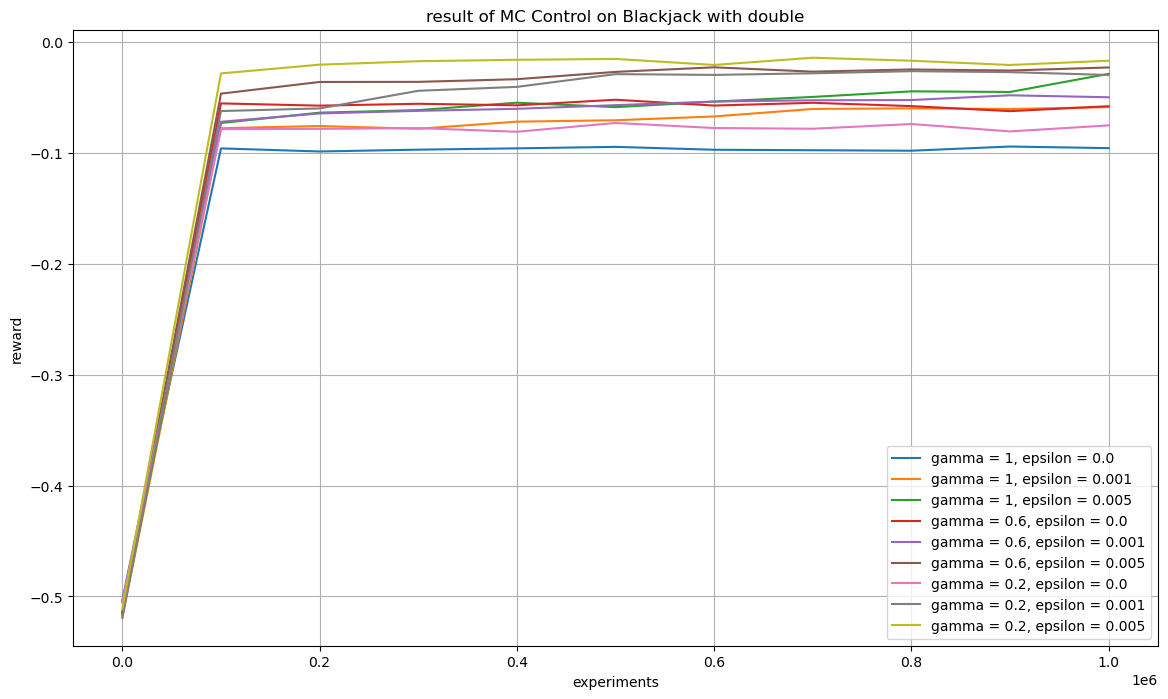

In [9]:
plot(results_dict, "result of MC Control on Blackjack with double")

6. Реализуйте вариант окружения BlackjackEnv из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).



Находится в файле blackjack_double_env_count.py

7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [10]:
gammas = [1, 0.6, 0.2]
epsilon = 0.005
results_dict = defaultdict() 
for gamma in gammas:
    env = BlackjackDoubleEnvWithCount(natural=True)
    print(f"current experiment gamma = {gamma}, epsilon = {epsilon}")
    mean_game_rewards_mc = run_experiments_mc_control(env, epsilon_greedy_policy, 5_000_000, gamma, epsilon)
    results_dict[(gamma, epsilon)] = mean_game_rewards_mc
    print(f"current experiment with gamma = {gamma}, epsilon = {epsilon} has finished")
    env.close()

current experiment gamma = 1, epsilon = 0.005


  0%|                                  | 4454/5000001 [00:03<44:32, 1868.89it/s]

-0.5192319754131778


  2%|▋                               | 102384/5000001 [00:12<30:10, 2704.61it/s]

-0.09048768596860944


  4%|█▎                              | 203535/5000001 [00:20<29:35, 2701.94it/s]

-0.08156845474492164


  6%|█▉                              | 304118/5000001 [00:27<29:19, 2668.36it/s]

-0.0710745354746263


  8%|██▌                             | 403309/5000001 [00:36<32:22, 2366.63it/s]

-0.07536444628370201


 10%|███▏                            | 502002/5000001 [00:44<29:40, 2525.68it/s]

-0.06947645574367348


 12%|███▊                            | 603023/5000001 [00:52<29:24, 2492.45it/s]

-0.0695677939009271


 14%|████▌                           | 703565/5000001 [01:00<27:15, 2626.20it/s]

-0.0671234155792619


 16%|█████▏                          | 803237/5000001 [01:08<27:49, 2513.48it/s]

-0.06621823501034842


 18%|█████▊                          | 902370/5000001 [01:16<26:16, 2599.24it/s]

-0.05857180545640771


 20%|██████▏                        | 1002128/5000001 [01:24<35:08, 1896.15it/s]

-0.0555736081453285


 22%|██████▊                        | 1103042/5000001 [01:33<25:10, 2579.14it/s]

-0.055500154607297465


 24%|███████▍                       | 1204154/5000001 [01:41<24:27, 2586.58it/s]

-0.05854211838054306


 26%|████████                       | 1302879/5000001 [01:49<23:02, 2674.98it/s]

-0.05007783120646076


 28%|████████▋                      | 1403097/5000001 [01:57<22:17, 2688.31it/s]

-0.0521702998638032


 30%|█████████▎                     | 1502909/5000001 [02:05<21:36, 2697.17it/s]

-0.052130187068945635


 32%|█████████▉                     | 1603010/5000001 [02:13<21:16, 2661.67it/s]

-0.04819980339149668


 34%|██████████▌                    | 1703746/5000001 [02:21<20:11, 2721.27it/s]

-0.050299092329840714


 36%|███████████▏                   | 1802232/5000001 [02:29<21:07, 2523.77it/s]

-0.04545628146077286


 38%|███████████▊                   | 1902870/5000001 [02:37<19:34, 2637.92it/s]

-0.04372399206063347


 40%|████████████▍                  | 2004157/5000001 [02:45<19:50, 2517.44it/s]

-0.04957653377401364


 42%|█████████████                  | 2102735/5000001 [02:53<17:48, 2712.56it/s]

-0.04194088376252608


 44%|█████████████▋                 | 2204080/5000001 [03:01<17:28, 2665.76it/s]

-0.04433131176826884


 46%|██████████████▎                | 2303946/5000001 [03:09<16:57, 2649.54it/s]

-0.050638245705441565


 48%|██████████████▉                | 2404657/5000001 [03:17<11:35, 3731.44it/s]

-0.04763912956800442


 50%|███████████████▌               | 2502704/5000001 [03:25<15:19, 2715.06it/s]

-0.04469442322383499


 52%|████████████████▏              | 2602394/5000001 [03:33<14:40, 2723.23it/s]

-0.04092036267878667


 54%|████████████████▊              | 2704278/5000001 [03:41<14:03, 2722.02it/s]

-0.043233572391810714


 56%|█████████████████▍             | 2803458/5000001 [03:49<14:04, 2601.78it/s]

-0.04472222647225325


 58%|█████████████████▉             | 2903103/5000001 [03:57<13:03, 2677.57it/s]

-0.046650114591291064


 60%|██████████████████▌            | 3003420/5000001 [04:05<12:08, 2740.61it/s]

-0.04303309945088469


 62%|███████████████████▏           | 3102335/5000001 [04:13<12:12, 2591.88it/s]

-0.040172429606530315


 64%|███████████████████▊           | 3202799/5000001 [04:21<11:58, 2502.34it/s]

-0.03757546266023935


 66%|████████████████████▍          | 3303162/5000001 [04:29<10:55, 2588.21it/s]

-0.04501973478284105


 68%|█████████████████████          | 3404073/5000001 [04:37<07:46, 3420.94it/s]

-0.04563684190461668


 70%|█████████████████████▋         | 3504020/5000001 [04:45<09:55, 2511.56it/s]

-0.04095482373776699


 72%|██████████████████████▎        | 3602253/5000001 [04:54<10:34, 2204.27it/s]

-0.0433727955086349


 74%|██████████████████████▉        | 3703397/5000001 [05:03<08:45, 2465.75it/s]

-0.03969278479659023


 76%|███████████████████████▌       | 3803299/5000001 [05:11<08:24, 2372.52it/s]

-0.038953634228111385


 78%|████████████████████████▏      | 3902294/5000001 [05:19<07:15, 2519.37it/s]

-0.04121426227882099


 80%|████████████████████████▊      | 4002338/5000001 [05:28<06:33, 2535.83it/s]

-0.03644029742832571


 82%|█████████████████████████▍     | 4103398/5000001 [05:36<05:42, 2615.12it/s]

-0.0409692834838896


 84%|██████████████████████████     | 4202347/5000001 [05:44<05:05, 2609.97it/s]

-0.039984492706250804


 86%|██████████████████████████▋    | 4303318/5000001 [05:52<04:35, 2525.80it/s]

-0.04062395475415818


 88%|███████████████████████████▎   | 4402914/5000001 [06:00<03:43, 2672.20it/s]

-0.04080942941985069


 90%|███████████████████████████▉   | 4502647/5000001 [06:08<03:05, 2679.82it/s]

-0.033186729857819904


 92%|████████████████████████████▌  | 4604409/5000001 [06:16<02:35, 2537.68it/s]

-0.04475216341239978


 94%|█████████████████████████████▏ | 4703653/5000001 [06:24<01:57, 2528.59it/s]

-0.03316255098874653


 96%|█████████████████████████████▊ | 4804123/5000001 [06:33<01:13, 2660.54it/s]

-0.033585152937100335


 98%|██████████████████████████████▍| 4904097/5000001 [06:41<00:35, 2730.61it/s]

-0.030640363592438245


100%|██████████████████████████████| 5000001/5000001 [06:48<00:00, 12230.62it/s]


-0.03539856412734122
current experiment with gamma = 1, epsilon = 0.005 has finished
current experiment gamma = 0.6, epsilon = 0.005


  0%|                                  | 4540/5000001 [00:03<43:06, 1931.65it/s]

-0.5189797657193337


  2%|▋                               | 103982/5000001 [00:12<32:17, 2527.18it/s]

-0.07585146057958816


  4%|█▎                              | 203590/5000001 [00:20<30:54, 2586.80it/s]

-0.0723709320831623


  6%|█▉                              | 303716/5000001 [00:28<30:33, 2561.88it/s]

-0.06315853913243884


  8%|██▌                             | 402751/5000001 [00:36<29:59, 2555.05it/s]

-0.05559821178699312


 10%|███▏                            | 502178/5000001 [00:44<30:08, 2486.74it/s]

-0.056180580437119314


 12%|███▊                            | 603304/5000001 [00:52<27:40, 2647.61it/s]

-0.05595803954794147


 14%|████▌                           | 704521/5000001 [01:00<27:06, 2640.85it/s]

-0.04917591682392532


 16%|█████▏                          | 802997/5000001 [01:09<27:58, 2500.97it/s]

-0.04793515602633839


 18%|█████▊                          | 903385/5000001 [01:17<26:44, 2553.38it/s]

-0.04644738348791939


 20%|██████▏                        | 1003109/5000001 [01:25<26:07, 2550.08it/s]

-0.03780324027773809


 22%|██████▊                        | 1102161/5000001 [01:33<26:02, 2494.09it/s]

-0.04345449869261434


 24%|███████▍                       | 1203371/5000001 [01:42<25:32, 2477.02it/s]

-0.04327139458625345


 26%|████████                       | 1303428/5000001 [01:50<24:55, 2472.12it/s]

-0.03679164281625644


 28%|████████▋                      | 1404272/5000001 [01:58<23:43, 2525.13it/s]

-0.03594434424117496


 30%|█████████▎                     | 1502565/5000001 [02:07<22:56, 2541.34it/s]

-0.03787132247929163


 32%|█████████▉                     | 1602564/5000001 [02:15<22:11, 2551.11it/s]

-0.03266629106909807


 34%|██████████▌                    | 1703603/5000001 [02:23<21:38, 2538.09it/s]

-0.03295583724771036


 36%|███████████▏                   | 1803592/5000001 [02:31<20:38, 2581.12it/s]

-0.03415969917529591


 38%|███████████▊                   | 1903733/5000001 [02:39<19:52, 2596.94it/s]

-0.031540066422549605


 40%|████████████▍                  | 2003148/5000001 [02:48<20:17, 2461.14it/s]

-0.02889422186774529


 42%|█████████████                  | 2104311/5000001 [02:56<18:55, 2549.87it/s]

-0.03349314582001563


 44%|█████████████▋                 | 2204513/5000001 [03:04<13:14, 3519.09it/s]

-0.030563572515176933


 46%|██████████████▎                | 2302894/5000001 [03:12<17:46, 2529.34it/s]

-0.03151513424563853


 48%|██████████████▉                | 2403031/5000001 [03:20<16:48, 2574.40it/s]

-0.02850148378511091


 50%|███████████████▌               | 2503752/5000001 [03:28<15:56, 2609.22it/s]

-0.029354451883681423


 52%|████████████████▏              | 2604413/5000001 [03:37<15:37, 2554.28it/s]

-0.02278726652683247


 54%|████████████████▊              | 2703846/5000001 [03:45<14:53, 2569.40it/s]

-0.024607042594730167


 56%|█████████████████▍             | 2802453/5000001 [03:53<13:50, 2647.44it/s]

-0.03057571875889553


 58%|█████████████████▉             | 2903157/5000001 [04:01<13:50, 2524.79it/s]

-0.023732416469312637


 60%|██████████████████▋            | 3004150/5000001 [04:09<12:45, 2607.93it/s]

-0.023937080895990868


 62%|███████████████████▏           | 3103340/5000001 [04:17<12:23, 2550.10it/s]

-0.022970527035886326


 64%|███████████████████▊           | 3204430/5000001 [04:26<08:37, 3471.43it/s]

-0.027170107880260055


 66%|████████████████████▍          | 3302823/5000001 [04:34<10:50, 2610.17it/s]

-0.020509294554367265


 68%|█████████████████████          | 3404294/5000001 [04:42<10:39, 2494.25it/s]

-0.024259651918999304


 70%|█████████████████████▋         | 3504093/5000001 [04:50<09:55, 2511.42it/s]

-0.024849736637102365


 72%|██████████████████████▎        | 3602926/5000001 [04:59<09:17, 2507.04it/s]

-0.025135680613896833


 74%|██████████████████████▉        | 3703947/5000001 [05:07<08:29, 2544.07it/s]

-0.016487036747013684


 76%|███████████████████████▌       | 3803443/5000001 [05:15<07:42, 2589.26it/s]

-0.02045065601825442


 78%|████████████████████████▏      | 3902309/5000001 [05:23<07:57, 2296.54it/s]

-0.02216817085920331


 80%|████████████████████████▊      | 4003371/5000001 [05:32<06:42, 2477.42it/s]

-0.019430061014156137


 82%|█████████████████████████▍     | 4103612/5000001 [05:40<05:58, 2499.23it/s]

-0.020178081607708814


 84%|██████████████████████████     | 4204136/5000001 [05:48<03:59, 3321.12it/s]

-0.02350404504793471


 86%|██████████████████████████▋    | 4303143/5000001 [05:56<04:33, 2546.87it/s]

-0.019266667139845695


 88%|███████████████████████████▎   | 4403602/5000001 [06:04<03:45, 2645.69it/s]

-0.02106244042622811


 90%|███████████████████████████▉   | 4504117/5000001 [06:13<03:14, 2550.61it/s]

-0.01797408833264671


 92%|████████████████████████████▌  | 4602272/5000001 [06:21<02:43, 2433.35it/s]

-0.018283971939700206


 94%|█████████████████████████████▏ | 4703274/5000001 [06:29<01:55, 2572.46it/s]

-0.021590320038060884


 96%|█████████████████████████████▊ | 4803864/5000001 [06:37<01:19, 2482.54it/s]

-0.023009879627526687


 98%|██████████████████████████████▍| 4902852/5000001 [06:46<00:37, 2618.72it/s]

-0.021193482861972472


100%|██████████████████████████████| 5000001/5000001 [06:54<00:00, 12072.04it/s]


-0.023078890167497763
current experiment with gamma = 0.6, epsilon = 0.005 has finished
current experiment gamma = 0.2, epsilon = 0.005


  0%|                                  | 4433/5000001 [00:03<44:25, 1874.46it/s]

-0.5211363124571226


  2%|▋                               | 103188/5000001 [00:12<33:09, 2461.28it/s]

-0.06579236793867689


  4%|█▎                              | 202666/5000001 [00:20<31:41, 2522.56it/s]

-0.052104922707290995


  6%|█▉                              | 302561/5000001 [00:28<31:51, 2457.61it/s]

-0.04697937988271609


  8%|██▌                             | 403751/5000001 [00:37<31:15, 2451.29it/s]

-0.045267881782461855


 10%|███▏                            | 503228/5000001 [00:45<30:59, 2418.10it/s]

-0.040588161813531795


 12%|███▊                            | 603484/5000001 [00:53<29:26, 2489.49it/s]

-0.04091311705137358


 14%|████▌                           | 704081/5000001 [01:01<28:24, 2520.34it/s]

-0.042318507663669847


 16%|█████▏                          | 803615/5000001 [01:10<27:57, 2500.90it/s]

-0.035122411789562644


 18%|█████▊                          | 903488/5000001 [01:18<27:14, 2506.30it/s]

-0.0312320538631638


 20%|██████▏                        | 1003210/5000001 [01:27<28:55, 2302.60it/s]

-0.028611489569967858


 22%|██████▊                        | 1102939/5000001 [01:35<27:22, 2372.01it/s]

-0.02917233365464605


 24%|███████▍                       | 1202722/5000001 [01:43<25:16, 2503.26it/s]

-0.024377552102667444


 26%|████████                       | 1302570/5000001 [01:52<24:05, 2558.42it/s]

-0.02942597187758478


 28%|████████▋                      | 1402287/5000001 [02:00<23:56, 2505.27it/s]

-0.03244894443192812


 30%|█████████▎                     | 1502625/5000001 [02:08<22:49, 2554.26it/s]

-0.027224241780985484


 32%|█████████▉                     | 1603935/5000001 [02:17<23:11, 2441.23it/s]

-0.025994564531240657


 34%|██████████▌                    | 1704414/5000001 [02:25<21:38, 2537.08it/s]

-0.025149022611475575


 36%|███████████▏                   | 1802188/5000001 [02:33<22:26, 2374.47it/s]

-0.024920053297801465


 38%|███████████▊                   | 1904299/5000001 [02:42<21:04, 2447.35it/s]

-0.027595846645367413


 40%|████████████▍                  | 2002832/5000001 [02:50<20:22, 2452.13it/s]

-0.02555103887377168


 42%|█████████████                  | 2103347/5000001 [02:59<20:27, 2360.60it/s]

-0.022415611814345992


 44%|█████████████▋                 | 2203182/5000001 [03:07<18:37, 2503.85it/s]

-0.024552576057078584


 46%|██████████████▎                | 2302308/5000001 [03:15<18:39, 2409.30it/s]

-0.024565779995197566


 48%|██████████████▉                | 2404464/5000001 [03:24<12:36, 3432.38it/s]

-0.016908664479442993


 50%|███████████████▌               | 2502261/5000001 [03:32<16:01, 2596.77it/s]

-0.01840328656402845


 52%|████████████████▏              | 2604053/5000001 [03:40<16:17, 2451.79it/s]

-0.018189902447830652


 54%|████████████████▊              | 2703427/5000001 [03:49<15:05, 2537.41it/s]

-0.018637075927835742


 56%|█████████████████▍             | 2803412/5000001 [03:57<14:24, 2541.34it/s]

-0.021579869938715978


 58%|█████████████████▉             | 2903174/5000001 [04:05<13:51, 2520.80it/s]

-0.02292198353529061


 60%|██████████████████▌            | 3002342/5000001 [04:13<13:16, 2508.70it/s]

-0.016898448149665256


 62%|███████████████████▏           | 3103820/5000001 [04:22<12:31, 2524.84it/s]

-0.019493999785706633


 64%|███████████████████▊           | 3203233/5000001 [04:30<12:28, 2401.46it/s]

-0.016344292060003887


 66%|████████████████████▍          | 3303191/5000001 [04:38<11:26, 2471.57it/s]

-0.018756107028604318


 68%|█████████████████████          | 3404162/5000001 [04:47<11:06, 2392.75it/s]

-0.014786462530217566


 70%|█████████████████████▋         | 3503145/5000001 [04:55<10:35, 2357.14it/s]

-0.01915726922817206


 72%|██████████████████████▎        | 3603090/5000001 [05:04<09:06, 2555.81it/s]

-0.014298116915456368


 74%|██████████████████████▉        | 3703566/5000001 [05:12<08:33, 2525.28it/s]

-0.013415272668689419


 76%|███████████████████████▌       | 3803797/5000001 [05:20<08:22, 2381.63it/s]

-0.018286233958705246


 78%|████████████████████████▏      | 3903664/5000001 [05:29<07:28, 2445.04it/s]

-0.014192588202810908


 80%|████████████████████████▊      | 4003947/5000001 [05:37<06:33, 2533.54it/s]

-0.015178943968127918


 82%|█████████████████████████▍     | 4103877/5000001 [05:45<05:58, 2502.58it/s]

-0.016787240485884453


 84%|██████████████████████████     | 4204197/5000001 [05:53<05:25, 2441.73it/s]

-0.016640611312516002


 86%|██████████████████████████▋    | 4304091/5000001 [06:02<04:42, 2464.59it/s]

-0.020668401958272083


 88%|███████████████████████████▎   | 4402246/5000001 [06:10<04:11, 2378.18it/s]

-0.014838153713577853


 90%|███████████████████████████▉   | 4503056/5000001 [06:18<03:15, 2547.37it/s]

-0.014596391005942792


 92%|████████████████████████████▌  | 4603061/5000001 [06:27<02:46, 2387.39it/s]

-0.01775239792371194


 94%|█████████████████████████████▏ | 4704024/5000001 [06:35<01:58, 2505.36it/s]

-0.015519377339689208


 96%|█████████████████████████████▊ | 4803945/5000001 [06:43<01:20, 2441.38it/s]

-0.012886127468545274


 98%|██████████████████████████████▍| 4904094/5000001 [06:52<00:39, 2440.20it/s]

-0.012159601939063775


100%|██████████████████████████████| 5000001/5000001 [07:00<00:00, 11886.01it/s]

-0.015019704067216894
current experiment with gamma = 0.2, epsilon = 0.005 has finished


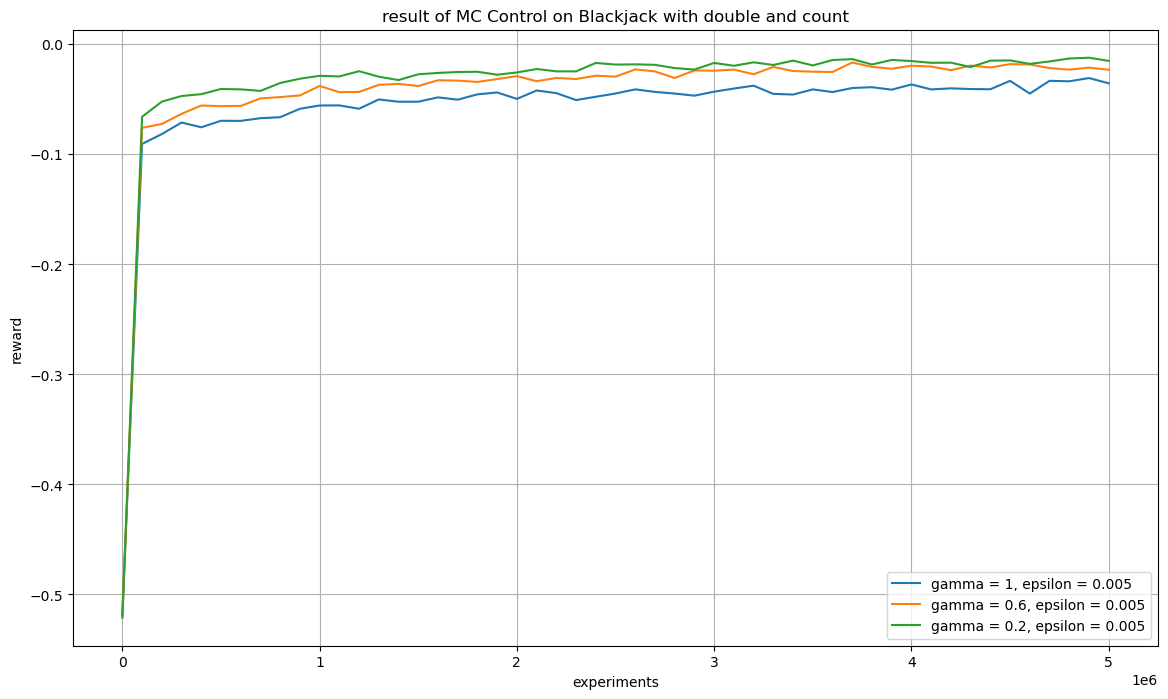

In [11]:
plot(results_dict, "result of MC Control on Blackjack with double and count")